<a href="https://colab.research.google.com/github/sznajder/Lectures/blob/master/MLP_HZZ4l_Keras_softmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP with SOFTMAX output 
for HZZ4l analysis using  Keras
Authors: Javier Duarte, Thong Nguyen     
Modified: Andre Sznajder

## **Mount Google Drive**

In [19]:
!fusermount -u drive
!pip install uproot
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'
!ls '/content/gdrive/My Drive/Colab Notebooks/Data/'

fusermount: failed to unmount /content/drive: No such file or directory
Mounted at /content/gdrive
_about.txt	   events.root		  ntuple_ggH_ZZ4mu.root
bolsas_astro.txt   GOOG.csv		  ntuple_qqH_ZZ4mu.root
bolsas_fisica.txt  jet_images.h5	  ntuple_SingleMuon_Endcap_9.root
deu.txt		   ntuple_bkg_ZZ4mu.root  ntuple_SingleNeutrino_PU200_63.root


#Load data using PANDAS data frames#
Now we load two different `NumPy` arrays. One corresponding to the VBF H->ZZ->4l signal and the other one corresponds to the QCD ZZ->4l background .

In [10]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

filename = {}
upfile = {}
data = {}
df = {}

#data_dir = '/Users/sznajder/cernbox/Data/2017ReducedTrees/histos2e2mu_25ns/'
#filename['sig'] = data_dir+'output_VBF_HToZZTo4L_M125_13TeV_powheg2_JHUGenV7011_pythia8_ext1.root'
#filename['bkg'] = data_dir+'bkg_merged_trees.root'

#data_dir = '/Users/sznajder/Google Drive/Colab Notebooks/Data/'
filename['sig'] = data_dir+'ntuple_qqH_ZZ4mu.root'
filename['bkg'] = data_dir+'ntuple_bkg_ZZ4mu.root'

treename = 'HZZ4LeptonsAnalysisReduced'

upfile['sig'] = uproot.open(filename['sig'])
upfile['bkg'] = uproot.open(filename['bkg'])

#upfile['bkg'] = uproot.iterate(,"*.root", treename)

# Variables from Roottree to be copyed to PANDA dataframe
VARS = ['f_lept1_pt','f_lept1_eta','f_lept1_phi', \
        'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
        'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
        'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
        'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
        'f_jet2_pt','f_jet2_eta','f_jet2_phi',\
        'f_weight','f_mass4l','f_massjj','f_deltajj']
        
# Convert the Root branches/leaves to dictionaries of Numpy arrays 
#data['sig'] = upfile['sig'][treename].arrays(VARS,namedecode="ascii")
#data['bkg'] = upfile['bkg'][treename].arrays(VARS,namedecode="ascii")
# Convert disctionary of arrays into Pandas dataframe
#df['sig'] = pd.DataFrame(data=data['sig'],columns=VARS)
#df['bkg'] = pd.DataFrame(data=data['bkg'],columns=VARS)

# Convert the Root branches/leaves directly to Pandas dataframe 
df['sig'] = upfile['sig'][treename].pandas.df(VARS)
df['bkg'] = upfile['bkg'][treename].pandas.df(VARS)

# Crop the background sample to have the same number of events as the signal sample
#df['bkg']=df['bkg'][:len(df['sig'])]

print(len(df['sig']))
print(len(df['bkg']))

# Remove undefined variable entries VARS[i] <= -999
#for i in range(len(VARS)): 
#  df['sig'] = df['sig'][(df['sig'][VARS[i]] > -999)]
#  df['bkg']= df['bkg'][(df['bkg'][VARS[i]] > -999)]


25817
58107


## **Specify the number of NN input variables **

In [11]:

# Define the NN input variables ( don't use  'f_weight', 'f_mass4l','f_massjj','f_deltajj' as inputs ! )
#NINPUT = len(VARS)-1
NINPUT = len(VARS)-4
print("NINPUT=",NINPUT)



NINPUT= 18


## Define the model using KERAS functional API 
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The output layer contains a single neuron using a sigmoid activation in order to a number between 0 and 1 to make binary classification

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [12]:
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Activation, Dense, Dropout
from keras.utils import np_utils

# Select the NN input variables. Using just lepton and and jets 4-mom ( low level veriables) ! 
input  = Input(shape=(NINPUT,), name = 'input') 
hidden = Dense(NINPUT*3 , name = 'hidden', kernel_initializer='normal', activation='relu')(input)
hidden = Dropout(rate=0.2)(hidden)
output  = Dense(2      , name = 'output', kernel_initializer='normal', activation='softmax')(hidden)
#hidden1 = Dense(NINPUT  , name = 'hidden1', kernel_initializer='normal', activation='relu')(input)
#hidden1 = Dropout(rate=0.2)(hidden1)
#hidden2 = Dense(int(NINPUT/2)  , name = 'hidden2', kernel_initializer='normal', activation='relu')(hidden1)
#hidden2 = Dropout(rate=0.2)(hidden2)
#hidden3 = Dense(int(NINPUT/4)  , name = 'hidden3', kernel_initializer='normal', activation='relu')(hidden2)
#hidden3 = Dropout(rate=0.2)(hidden3)
#output  = Dense(2      , name = 'output', kernel_initializer='normal', activation='softmax')(hidden3)

# create the model
model = Model(inputs=input, outputs=output)
# Define the optimizer ( minimization algorithm )
#optim = SGD(lr=0.01,decay=1e-6)
optim = Adam()
# compile the model
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
# print the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 18)                0         
_________________________________________________________________
hidden (Dense)               (None, 54)                1026      
_________________________________________________________________
dropout_2 (Dropout)          (None, 54)                0         
_________________________________________________________________
output (Dense)               (None, 2)                 110       
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


## Dividing the data into testing and training dataset and renormalizing events weights

We will split the data into two parts (one for training+validation and one for testing). 


In [13]:
# Add the variable isSignal to the dataframe containing the signal and background events
df['sig']['isSignal'] = np.ones(len(df['sig'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 


# Renormalizes the events weights to give unit sum in the signal and background dataframes
# This is necessary for the NN to learn signal and background in the same proportion , 
#   independently of number of events and absolute weights of events in each sample !
df['sig']['f_weight']=df['sig']['f_weight']/df['sig']['f_weight'].sum(axis=0)
df['bkg']['f_weight']=df['bkg']['f_weight']/df['bkg']['f_weight'].sum(axis=0)


# Concatanate the signal and background in a single  data frames 
df_all = pd.concat([df['sig'],df['bkg']])

# Transform the data frame into a 2-dim numpy array and get the target output ( last entry )
NVARS=len(VARS)
print("NVARS=",NVARS)
dataset = df_all.values

# Random shuffles the dataset to mix signal and background events before splitting between train and test samples
np.random.shuffle(dataset)

X = dataset[:,0:NVARS]
Y = dataset[:,-1]
Y = np_utils.to_categorical(Y, 2)

print("X=",X)
print("Y=",Y)

# Split the sample into train and test  
from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Get events weights
weights=X_train_val[:,18]

print("Signal Max Weight=",df['sig']['f_weight'].max(axis=0))
print("Signal Min Weight=",df['sig']['f_weight'].min(axis=0))
print("Background Max Weight=",df['bkg']['f_weight'].max(axis=0))
print("Background Min Weight=",df['bkg']['f_weight'].min(axis=0))


NVARS= 22
X= [[ 3.07505798e+01  1.27437901e+00  1.70030582e+00 ...  1.23047890e+02
   3.71148590e+02  3.25640655e+00]
 [ 3.02125969e+01 -1.31058657e+00  2.48251748e+00 ...  2.15001892e+02
  -9.99000000e+02 -9.99000000e+02]
 [ 2.92876720e+01 -6.75566435e-01  5.11648715e-01 ...  1.84038193e+02
  -9.99000000e+02 -9.99000000e+02]
 ...
 [ 6.13348198e+01 -7.74336517e-01 -2.67291594e+00 ...  1.97752396e+02
  -9.99000000e+02 -9.99000000e+02]
 [ 1.08771141e+02 -1.18934393e+00 -3.97866338e-01 ...  4.40411896e+02
  -9.99000000e+02 -9.99000000e+02]
 [ 4.24174652e+01  7.92106539e-02  2.20217299e+00 ...  9.08872452e+01
  -9.99000000e+02 -9.99000000e+02]]
Y= [[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Signal Max Weight= 9.99764961306937e-05
Signal Min Weight= 5.0672088747205635e-08
Background Max Weight= 3.271547029726207e-05
Background Min Weight= 1.3995708059155731e-07


## Run NN Training 


In [14]:
# Number of training epochs
nepochs=20 
# Batch size
batch=100
# Train classifier
history = model.fit(X_train_val[:,0:NINPUT], 
                    Y_train_val,
                    epochs=nepochs, 
                    sample_weight=weights,
                    batch_size=batch, 
                    verbose=1, # switch to 1 for more verbosity 
                    validation_split=0.3)


Train on 46997 samples, validate on 20142 samples
Epoch 1/20
46997/46997 [==============================] - 1s 28us/step - loss: 2.2111e-05 - acc: 0.9189 - val_loss: 2.1557e-05 - val_acc: 0.9116
Epoch 2/20
46997/46997 [==============================] - 1s 25us/step - loss: 2.1252e-05 - acc: 0.9245 - val_loss: 2.1248e-05 - val_acc: 0.9287
Epoch 3/20
46997/46997 [==============================] - 1s 25us/step - loss: 2.1241e-05 - acc: 0.9245 - val_loss: 2.1287e-05 - val_acc: 0.9296
Epoch 4/20
46997/46997 [==============================] - 1s 28us/step - loss: 2.1157e-05 - acc: 0.9260 - val_loss: 2.1266e-05 - val_acc: 0.9215
Epoch 5/20
46997/46997 [==============================] - 1s 27us/step - loss: 2.1223e-05 - acc: 0.9216 - val_loss: 2.1406e-05 - val_acc: 0.9089
Epoch 6/20
46997/46997 [==============================] - 1s 24us/step - loss: 2.1101e-05 - acc: 0.9270 - val_loss: 2.1254e-05 - val_acc: 0.9196
Epoch 7/20
46997/46997 [==============================] - 1s 20us/step - loss: 2

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

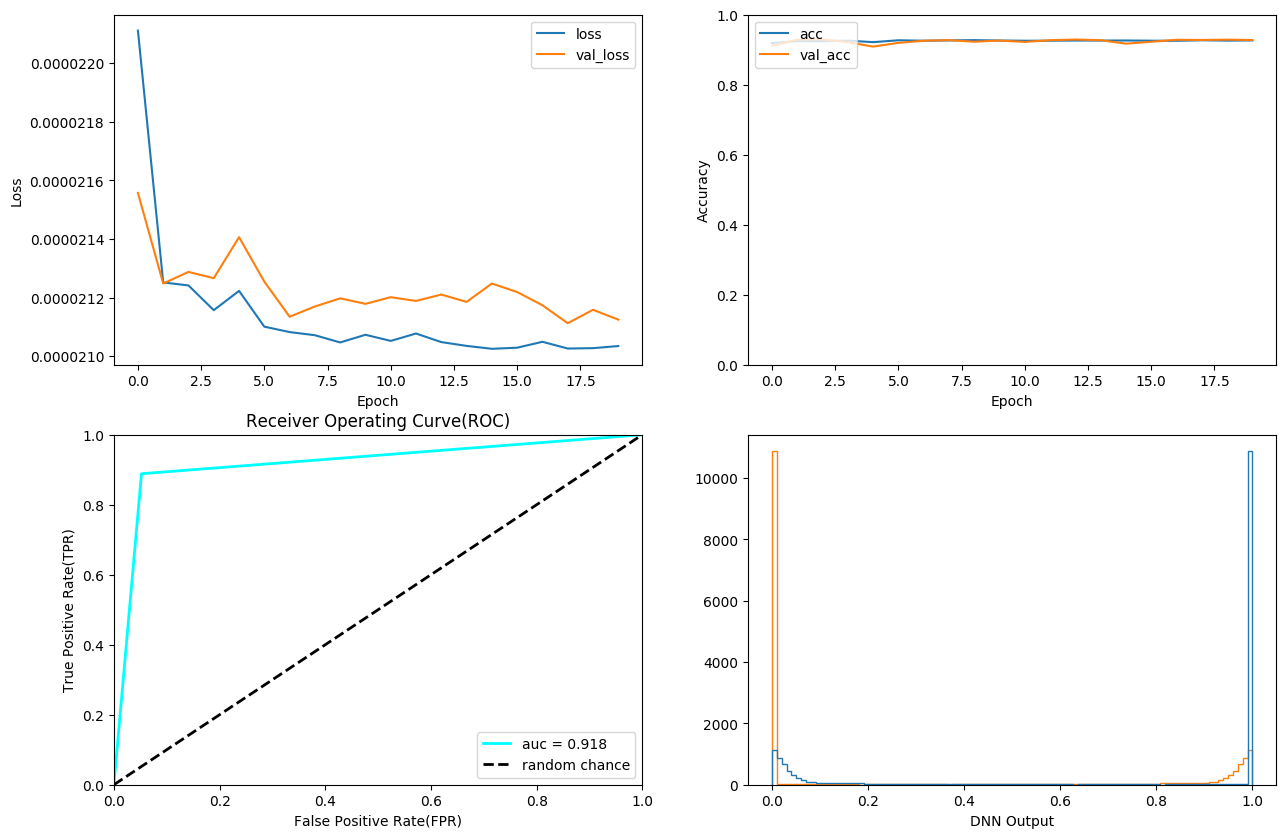

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain the NN predictions for test sample
Y_predict = model.predict(X_test[:,0:NINPUT])


plt.style.use('default')
plt.figure(figsize=(15,10))

# plot loss vs epoch
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
#ax.set_ylim([0, 1])
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.set_ylim([0, 1.0])
ax.legend(loc="upper left")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1))
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate(FPR)')
ax.set_ylabel('True Positive Rate(TPR)')
ax.set_title('Receiver Operating Curve(ROC)')
ax.legend(loc="lower right")

# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 100)
ax.hist(Y_predict, bins=X, label='bkg',histtype='step')
#ax.hist(Y_train_val, bins=X, label='bkg',histtype='step')

ax.set_xlabel('DNN Output')

plt.show()

# Plot  $m_{jj}$, $\eta_{j}$ and $m_{4l}$  for NN output > cut to show that the NN did learned the physics !


0.8885869565217391
0.5139712108382727


(50, 400)

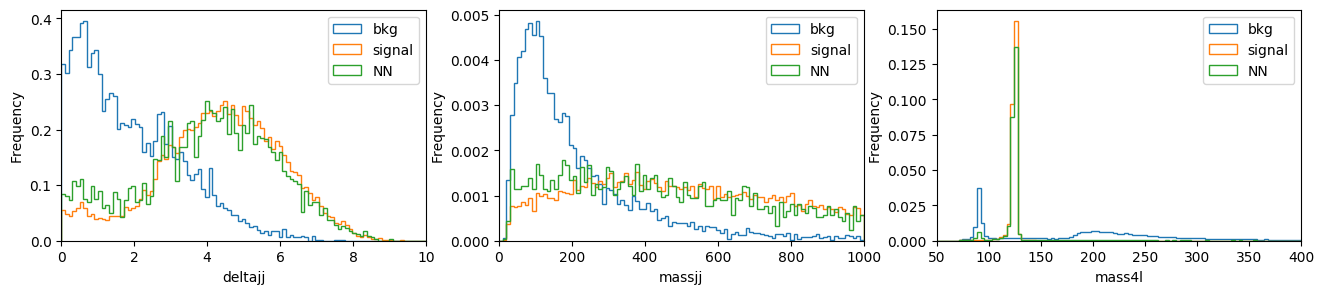

In [16]:

import matplotlib.pyplot as plt

# Define the data frame for NN predictions and high level variables
data = pd.DataFrame({'f_mass4l':X_test[:,19],'f_massjj':X_test[:,20],'f_deltajj':X_test[:,21],'isSignal':np.argmax(Y_test[:],axis=1),'NNoutput':np.argmax(Y_predict[:],axis=1)})


# Selects events with NNoutput > cut
cut = 0.5 
data_sel   = data[(data['NNoutput'] >= cut)]
data_TP    = data[(data['NNoutput'] >= cut) & (data['isSignal'] == 1)]
data_unsel = data[(data['NNoutput'] < cut)]
data_TN    = data[(data['NNoutput'] < cut) & (data_unsel['isSignal'] == 0)]

TP = len(data_TP)
FP = len(data_sel) - TP
TN = len(data_TN)
FN = len(data_unsel) - TN

truepositiverate = float(TP)/(TP+FN)
fakepositiverate = float(FP)/(FP+FN)
print(truepositiverate)
print(fakepositiverate)
    
# Plot  delta_eta between jets for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 3),dpi=100)

plt.subplot(1, 3, 1)
plt.xlabel('deltajj')
X = np.linspace(0.0,10.,100)
df['bkg']['f_deltajj'].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df['sig']['f_deltajj'].plot.hist(bins=X, label='signal',histtype='step', density=1)
data_sel['f_deltajj'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,10)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(1, 3, 2)
plt.xlabel('massjj')
X = np.linspace(0.0,1000.,100)
df['bkg']['f_massjj'].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df['sig']['f_massjj'].plot.hist(bins=X, label='signal',histtype='step', density=1)
data_sel['f_massjj'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,1000)

# Plot 4l invariant mass for signal, background and NN selected events 
plt.subplot(1, 3, 3)
plt.xlabel('mass4l')
X = np.linspace(50.,400.,100)
df['bkg']['f_mass4l'].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df['sig']['f_mass4l'].plot.hist(bins=X, label='signal',histtype='step', density=1)
data_sel['f_mass4l'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(50,400)





**Question 1:** What happens if you increase/decrease the number of hidden layers ?



**Question 2:** What happens if you increase/decrease the number of nodes per hidden layer ?



**Question 3:** What happens if you remove dropout ?



**Question 4:** What happens if you change the batch size  ?



